In [40]:
import os
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [41]:
df = pd.read_csv('/content/TMP/uci-news-aggregator.csv')
df.shape

(422419, 8)

In [42]:
df.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [43]:
df.columns

Index(['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME',
       'TIMESTAMP'],
      dtype='object')

In [44]:
df1 = df[['CATEGORY', 'TITLE']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['TITLE'])]

# Renaming second column for a simpler name
df1.columns = ['CATEGORY', 'TITLE'] 

df1.shape

(422419, 2)

In [45]:
total = df1['TITLE'].notnull().sum()
round((total/len(df)*100),1)

100.0

In [46]:
pd.DataFrame(df.CATEGORY.unique()).values

array([['b'],
       ['t'],
       ['e'],
       ['m']], dtype=object)

In [47]:
df2 = df1.sample(10000, random_state=1).copy()

In [48]:
df2.replace({'CATEGORY': 
             {'b': 'business',
              't': 'science',
              'e': 'entertaiment',
              'm': 'health'
              }}, 
            inplace= True)

In [49]:
df2.head()

,CATEGORY,TITLE
383386,business,Murdoch's bid for Time Warner rejected
352807,business,Rescuers close in on 3 trapped Honduran miners...
106299,entertaiment,Johnny Depp - Johnny Depp Served With Legal Pa...
256199,science,"Apple prepping move into ""smart home"" connecti..."
43325,entertaiment,Ripped First Look: Dwayne Johnson as Brett Rat...


In [50]:
pd.DataFrame(df2.CATEGORY.unique())

,0
0,business
1,entertaiment
2,science
3,health


In [51]:
df2['category_id'] = df2['CATEGORY'].factorize()[0]
category_id_df = df2[['CATEGORY', 'category_id']].drop_duplicates()

category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'CATEGORY']].values)

# New dataframe
df2.head()

,CATEGORY,TITLE,category_id
383386,business,Murdoch's bid for Time Warner rejected,0
352807,business,Rescuers close in on 3 trapped Honduran miners...,0
106299,entertaiment,Johnny Depp - Johnny Depp Served With Legal Pa...,1
256199,science,"Apple prepping move into ""smart home"" connecti...",2
43325,entertaiment,Ripped First Look: Dwayne Johnson as Brett Rat...,1


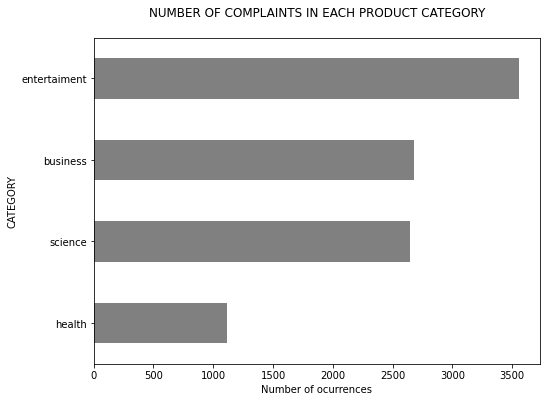

In [52]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('CATEGORY').TITLE.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [28]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

features = tfidf.fit_transform(df2.TITLE).toarray()

labels = df2.CATEGORY

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 3714 features (TF-IDF score of unigrams and bigrams)


In [53]:
N = 3
for CATEGORY, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(CATEGORY))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> business:
  * Most Correlated Unigrams are: fedex, fb, zuckerberg
  * Most Correlated Bigrams are: fast furious, fault stars, fda approves

==> entertaiment:
  * Most Correlated Unigrams are: fedex, fb, zuckerberg
  * Most Correlated Bigrams are: fast furious, fault stars, fda approves

==> health:
  * Most Correlated Unigrams are: fedex, fb, zuckerberg
  * Most Correlated Bigrams are: fast furious, fault stars, fda approves

==> science:
  * Most Correlated Unigrams are: fedex, fb, zuckerberg
  * Most Correlated Bigrams are: fast furious, fault stars, fda approves


In [54]:
X = df2['TITLE'] # Collection of documents
y = df2['CATEGORY'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.23,
                                                    random_state = 0)

In [55]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [56]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.8627,0.007588
LogisticRegression,0.8584,0.007948
MultinomialNB,0.8602,0.010196
RandomForestClassifier,0.4339,0.003070


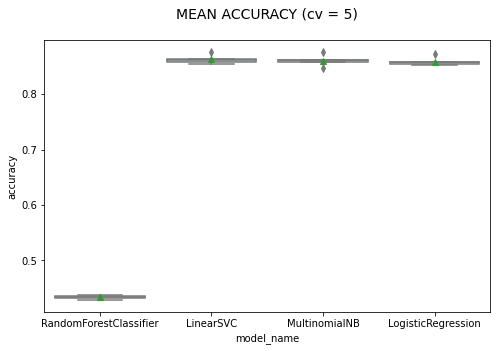

In [57]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [58]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [59]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df2['CATEGORY'].unique()))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

    business       0.82      0.84      0.83       669
entertaiment       0.90      0.92      0.91       899
     science       0.83      0.72      0.77       263
      health       0.84      0.83      0.84       669

    accuracy                           0.86      2500
   macro avg       0.85      0.83      0.84      2500
weighted avg       0.86      0.86      0.86      2500



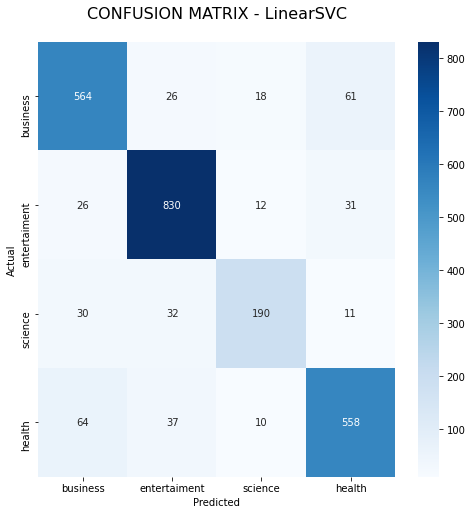

In [60]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.CATEGORY.values, 
            yticklabels=category_id_df.CATEGORY.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [61]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['CATEGORY', 
                                                                'TITLE']])
      print('')

'entertaiment' predicted as 'business' : 26 examples.


,CATEGORY,TITLE



'science' predicted as 'business' : 30 examples.


,CATEGORY,TITLE



'health' predicted as 'business' : 64 examples.


,CATEGORY,TITLE



'business' predicted as 'entertaiment' : 26 examples.


,CATEGORY,TITLE



'science' predicted as 'entertaiment' : 32 examples.


,CATEGORY,TITLE



'health' predicted as 'entertaiment' : 37 examples.


,CATEGORY,TITLE



'business' predicted as 'health' : 61 examples.


,CATEGORY,TITLE



'entertaiment' predicted as 'health' : 31 examples.


,CATEGORY,TITLE


In [62]:
model.fit(features, labels)

N = 4
for CATEGORY, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'business':
  * Top unigrams: obamacare, oil, ipo, delivery
  * Top bigrams: general electric, american apparel, tax day, tesla motors

==> 'business':
  * Top unigrams: trailer, actor, music, movie
  * Top bigrams: box office, true blood, ac dc, guardians galaxy

==> 'business':
  * Top unigrams: google, apple, facebook, microsoft
  * Top bigrams: gas prices, video game, virtual reality, billion deal

==> 'business':
  * Top unigrams: mers, ebola, fda, polio
  * Top bigrams: relay life, air pollution, dr oz, heart attacks


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [82]:
test_mod = """What do you think if you don't have money?"""

print(model.predict(fitted_vectorizer.transform([test_mod])))

['science']
